In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator, RegularGridInterpolator
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
import sys
import os
import json
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score
from tqdm import tqdm
from codebase.general import *
from codebase.fno_functions import *

In [2]:
# Load data
file_path = r'datasets/4000.am'
sigma = 20
encoder_data_history_range = (-40,0+1,10)
slices = [slice(0,1001,1),slice(0,250,1),slice(250,500,1)]
data = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices, sigma=sigma)
data_train = data
slices_test = [slice(0,1001,1),slice(250,500,1),slice(250,500,1)]
data_test = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices_test, sigma=sigma)

n_grid = 16
x = np.linspace(0,1,n_grid)
X,Y = np.meshgrid(x,x)
nodes = np.stack([X,Y],-1)

n_skip = 30
n_max = 0
X_train = np.stack([GetX(data_train[i]) for i in range(0,len(data)-n_max,n_skip)],axis=0)
Y_train = np.stack([data_train[i]['interpSD'](nodes) for i in range(0,len(data)-n_max,n_skip)],axis=0)
x_mean,x_std = X_train.mean((0,1,2),keepdims=True), X_train.std((0,1,2),keepdims=True)
y_mean,y_std = Y_train.mean((0,1,2),keepdims=True), Y_train.std((0,1,2),keepdims=True)
X_train = (X_train-x_mean)/x_std

X_test = np.stack([GetX(data_test[i]) for i in range(0,len(data),100)],axis=0)
Y_test = np.stack([data_test[i]['interpSD'](nodes) for i in range(0,len(data),100)],axis=0)
X_test = (X_test-x_mean)/x_std

(1001, 250, 250, 2)
(1001, 250, 250, 2)


/Users/jakubhorsky/Documents/Programming/PythonProjects/SINN_share/SINNs/.sinnvenv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/300


33/33 [==============================] - 3s 14ms/step - loss: 0.7905 - mae: 0.6813 - val_loss: 0.9026 - val_mae: 0.7315 - lr: 0.0010
Epoch 2/300
33/33 [==============================] - 0s 4ms/step - loss: 0.2442 - mae: 0.3787 - val_loss: 0.7202 - val_mae: 0.6595 - lr: 0.0010
Epoch 3/300
33/33 [==============================] - 0s 4ms/step - loss: 0.1406 - mae: 0.2845 - val_loss: 0.6196 - val_mae: 0.6054 - lr: 0.0010
Epoch 4/300
33/33 [==============================] - 0s 4ms/step - loss: 0.0987 - mae: 0.2384 - val_loss: 0.5850 - val_mae: 0.5884 - lr: 0.0010
Epoch 5/300
33/33 [==============================] - 0s 4ms/step - loss: 0.0768 - mae: 0.2111 - val_loss: 0.5579 - val_mae: 0.5739 - lr: 0.0010
Epoch 6/300
33/33 [==============================] - 0s 4ms/step - loss: 0.0595 - mae: 0.1855 - val_loss: 0.5529 - val_mae: 0.5729 - lr: 0.0010
Epoch 7/300
33/33 [==============================] - 0s 5ms/step - loss: 0.0490 - mae: 0.1695 - val_loss: 0.5536 - val_mae: 0.5748 - lr: 0.0010
Epo

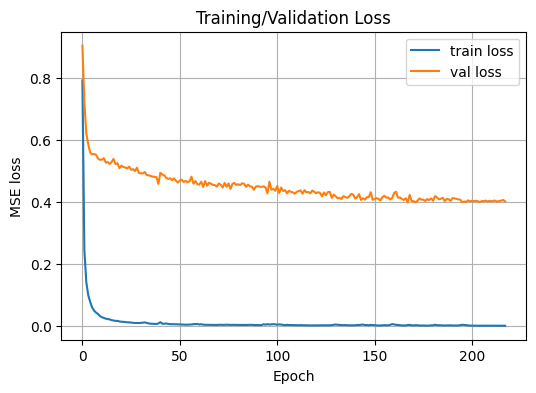

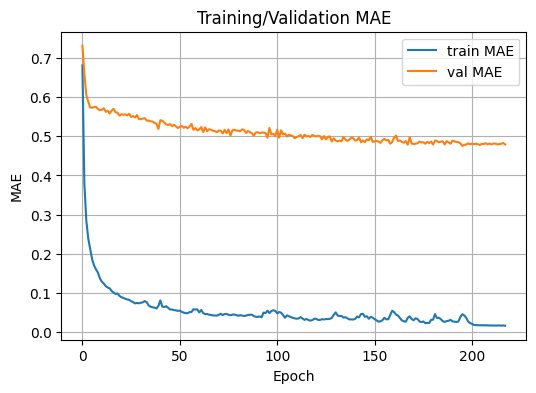

In [3]:
# Build model

H = int(X_train.shape[1])
W = int(X_train.shape[2])
Cin = int(X_train.shape[3])
Cout = int(Y_train.shape[3])


width = 16
model = build_lp_fno_all_sides(
    H, W, Cin, Cout=Cout,
    side_width=width, side_depth=1, side_modes=4,
    cross_width=width,
    trunk_width=width, trunk_depth=1, trunk_modes=(4, 4),
    conv_blocks=0, profile_hidden=width,
)


# Compile
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-5, verbose=1)
]

# Train
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=300,
    batch_size=1,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate
test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MSE: {test_loss:.6f}   |   Test MAE: {test_mae:.6f}")

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training/Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_test2 = np.stack([GetX(data_test[i]) for i in range(0,len(data),30)],axis=0)
Y_test2 = np.stack([data_test[i]['interpSD'](nodes) for i in range(0,len(data),30)],axis=0)
X_test2 = (X_test2-x_mean)/x_std

Y_pred2 = model.predict(X_test2)
print('Test set 2 MAE:', np.mean(np.abs(Y_pred2 - Y_test2)))
print('Test set 2 MSE:', np.mean((Y_pred2 - Y_test2)**2))
print('Test set 2 max percentage error:', np.max(Y_pred2 - Y_test2)/(Y_test2.max()-Y_test2.min()))
print('Test set 2 r2', r2_score(Y_test2.reshape(-1), Y_pred2.reshape(-1)))

2/2 [==============================] - 0s 3ms/step
Test set 2 MAE: 0.46631685461921396
Test set 2 MSE: 0.37265845433509476
Test set 2 max percentage error: 0.46208574400243096
Test set 2 r2 0.5248731447534674
